In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates


In [2]:
ds = xr.open_dataset("../tmp/wmo6900804_blacksea.nc") #downloaded for black sea data
print(ds)

<xarray.Dataset> Size: 2MB
Dimensions:                (N_POINTS: 10691)
Coordinates:
    LATITUDE               (N_POINTS) float64 86kB ...
    LONGITUDE              (N_POINTS) float64 86kB ...
    TIME                   (N_POINTS) datetime64[ns] 86kB ...
  * N_POINTS               (N_POINTS) int64 86kB 0 1 2 3 ... 10688 10689 10690
Data variables: (12/30)
    CONFIG_MISSION_NUMBER  (N_POINTS) int32 43kB ...
    CYCLE_NUMBER           (N_POINTS) int32 43kB ...
    DIRECTION              (N_POINTS) <U1 43kB ...
    DOXY                   (N_POINTS) float32 43kB ...
    DOXY_ADJUSTED          (N_POINTS) float32 43kB ...
    DOXY_ADJUSTED_ERROR    (N_POINTS) float32 43kB ...
    ...                     ...
    TEMP_ADJUSTED          (N_POINTS) float32 43kB ...
    TEMP_ADJUSTED_ERROR    (N_POINTS) float32 43kB ...
    TEMP_ADJUSTED_QC       (N_POINTS) int32 43kB ...
    TEMP_DATA_MODE         (N_POINTS) <U1 43kB ...
    TEMP_QC                (N_POINTS) int32 43kB ...
    TIME_QC        

In [3]:
# Extract necessary variables
# pressure = ds["PRES"].values  # Depth or pressure
# time = ds["TIME"].values
# doxy = ds["DOXY_ADJUSTED"].values
time_min = ds["TIME"].min().values
time_max = ds["TIME"].max().values
print(time_min, time_max)

2011-03-19T07:35:23.000000000 2013-07-01T08:37:13.000000000


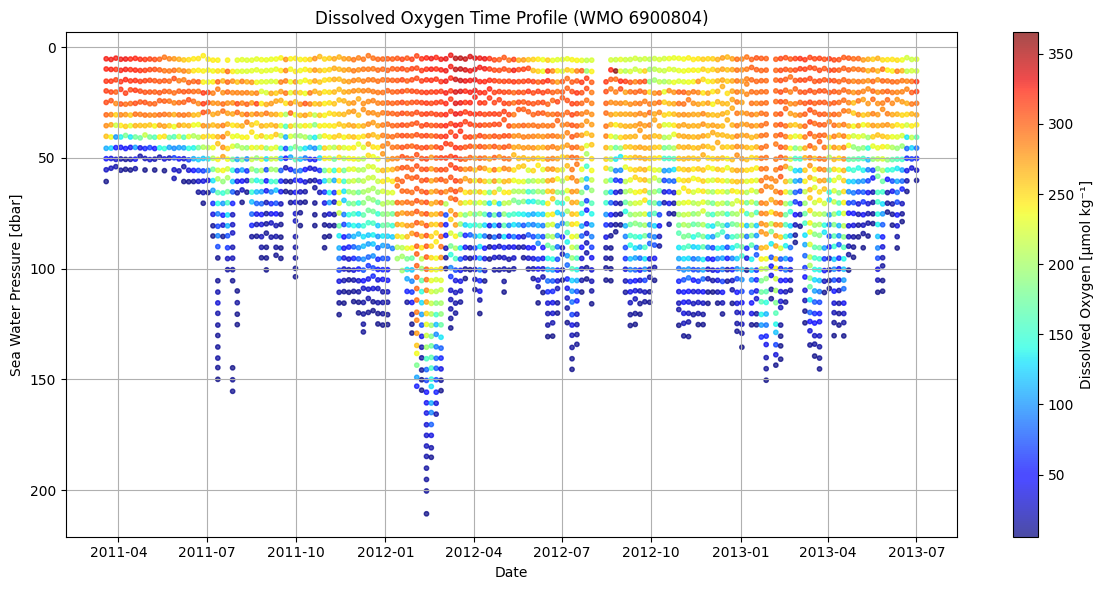

In [4]:
# Extract variables from dataset
doxy = ds["DOXY_ADJUSTED"]
time = ds["TIME"]
pressure = ds["PRES"]

# Filter out NaN values for plotting
valid_mask = ~np.isnan(doxy) & ~np.isnan(pressure) & ~np.isnan(time)
doxy = doxy[valid_mask]
pressure = pressure[valid_mask]
time = time[valid_mask]

# Create the plot
plt.figure(figsize=(12, 6))
sc = plt.scatter(time, pressure, c=doxy, cmap="jet", s=10, alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis for depth
cbar = plt.colorbar(sc)
cbar.set_label("Dissolved Oxygen [µmol kg⁻¹]")
plt.title("Dissolved Oxygen Time Profile (WMO 6900804)")
plt.xlabel("Date")
plt.ylabel("Sea Water Pressure [dbar]")
plt.grid()

plt.tight_layout()
plt.show()

In [5]:
print(f"Valid data points: {len(doxy)}")

Valid data points: 3356


In [6]:
# Load data
time = ds["TIME"].values
pressure = ds["PRES"].values
doxy = ds["DOXY"].values

# Filter out invalid values
valid_mask = ~np.isnan(pressure) & ~np.isnan(doxy)
time = time[valid_mask]
pressure = pressure[valid_mask]
doxy = doxy[valid_mask]

# Convert time to numeric for interpolation
time_numeric = (time - time.min()) / np.timedelta64(1, 'D')  # Days since the start

# Create a combined time grid including original and interpolated points
n_interp_points = 300
interp_time_numeric = np.linspace(time_numeric.min(), time_numeric.max(), n_interp_points)
combined_time_numeric = np.unique(np.sort(np.concatenate([time_numeric, interp_time_numeric])))
pressure_grid = np.linspace(pressure.min(), pressure.max(), 100)  # Pressure grid

# Create a meshgrid for interpolation
time_mesh_numeric, pressure_mesh = np.meshgrid(combined_time_numeric, pressure_grid)

# Interpolate data onto the grid
doxy_grid = griddata(
    (time_numeric, pressure),
    doxy,
    (time_mesh_numeric, pressure_mesh),
    method='linear'
)

# Convert numeric time back to datetime for plotting
time_grid = time.min() + combined_time_numeric * np.timedelta64(1, 'D')

# Initialize arrays for valid depth ranges
valid_min_depths = np.full_like(combined_time_numeric, np.nan)
valid_max_depths = np.full_like(combined_time_numeric, np.nan)

# Find valid depth ranges for each time point
tolerance = np.timedelta64(1, 'D')
for t_idx, t_val in enumerate(time_grid):
    time_diff = np.abs(time - t_val)
    matching_times = time_diff <= tolerance
    if np.any(matching_times):
        valid_depths = pressure[matching_times]
        valid_min_depths[t_idx] = np.nanmin(valid_depths)
        valid_max_depths[t_idx] = np.nanmax(valid_depths)

# Forward-fill remaining NaN values for valid depth ranges
for i in range(1, len(valid_min_depths)):
    if np.isnan(valid_min_depths[i]):
        valid_min_depths[i] = valid_min_depths[i - 1]
        valid_max_depths[i] = valid_max_depths[i - 1]

# Mask out regions outside valid depths
for t_idx in range(len(time_grid)):
    mask = (pressure_grid >= valid_min_depths[t_idx]) & (pressure_grid <= valid_max_depths[t_idx])
    doxy_grid[~mask, t_idx] = np.nan



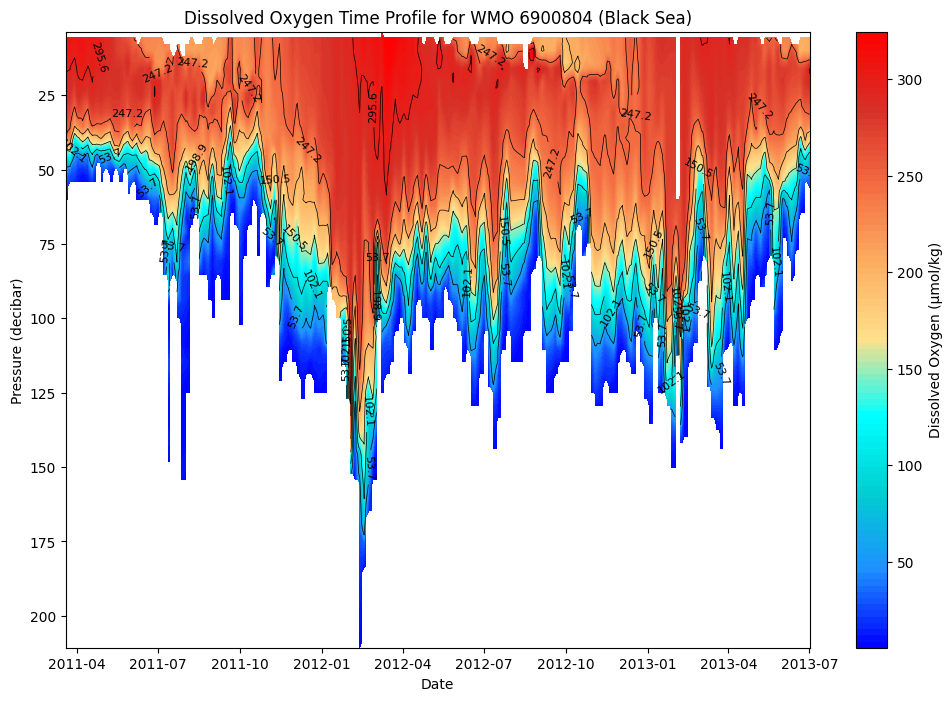

In [7]:
# Custom colormap
colors = ["#0000FF", "#1E90FF", "#00CED1", "#00FFFF", "#fee08b", "#fdae61", "#f46d43", "#d73027", "#ff0000"]
cmap = LinearSegmentedColormap.from_list('DissolvedOxygen', colors, N=256)

# Determine levels based on valid data range
doxy_min = np.nanmin(doxy_grid)
doxy_max = np.nanmax(doxy_grid)
levels = np.linspace(doxy_min, doxy_max, 100)

# Plot the results
plt.figure(figsize=(12, 8))
contourf = plt.contourf(time_grid, pressure_grid, doxy_grid, levels=levels, cmap=cmap)
contours = plt.contour(time_grid, pressure_grid, doxy_grid, levels=levels[::15], colors='black', linewidths=0.5)  # Contour lines every 10 levels
plt.clabel(contours, inline=True, fontsize=8)

# Add colorbar
cbar = plt.colorbar(contourf, label='Dissolved Oxygen (µmol/kg)')
cbar.set_ticks(ticks=[50, 100, 150, 200, 250, 300])
# Labels and titles
plt.gca().invert_yaxis()
plt.title("Dissolved Oxygen Time Profile for WMO 6900804 (Black Sea)")
plt.xlabel("Date")
plt.ylabel("Pressure (decibar)")

plt.show()



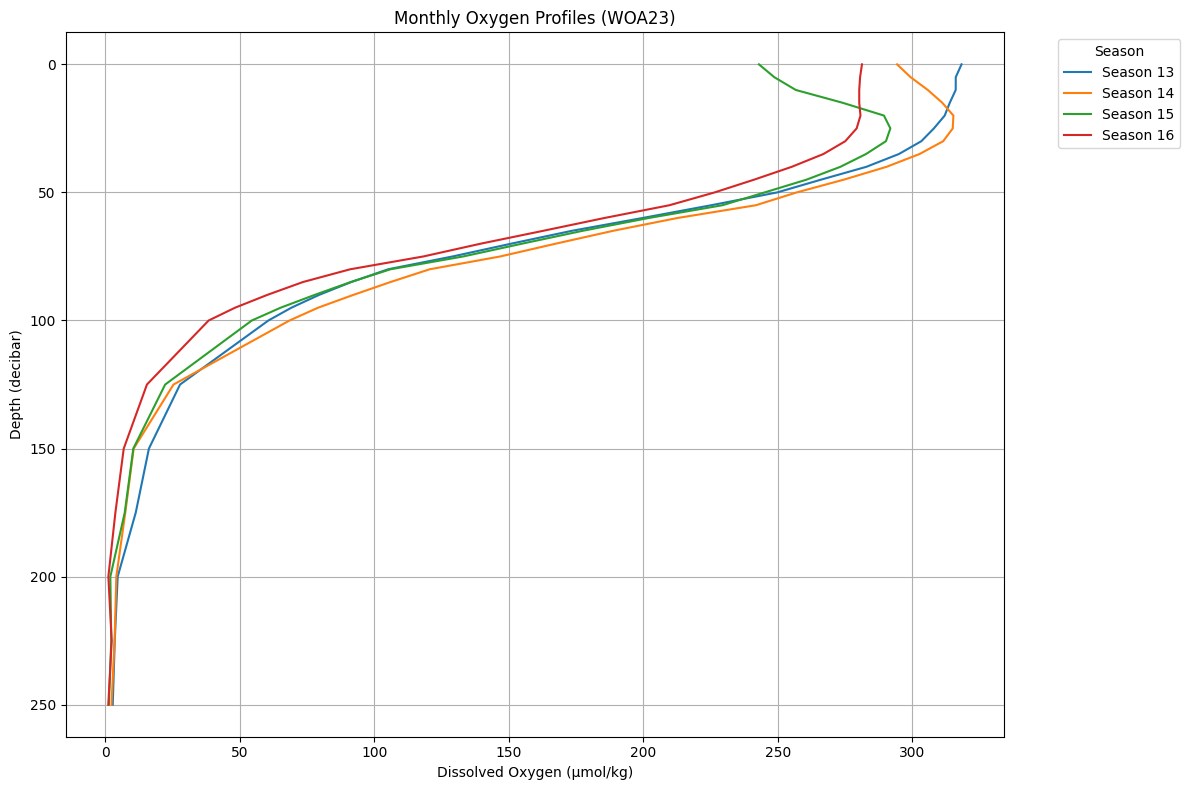

In [10]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Fetch data from the WOA23 API
base_url = "https://eco.odb.ntu.edu.tw/api/woa23"
map_params = {
    "lon0": 29,  # Black Sea bounding box
    "lat0": 41,
    "lon1": 41,
    "lat1": 45,
    "dep0": 0,
    "dep1": 250,
    "parameter": "oxygen",
    "time_period": "13,14,15,16", #",".join(map(str, range(1, 13))),  # Monthly time periods
    "append": "an",  # Analyzed means
    "grid": 1,       # 1-degree grid
}

response = requests.get(base_url, params=map_params)
map_data = response.json()

# Convert JSON to a DataFrame
df = pd.DataFrame(map_data)
df["time_period"] = df["time_period"].astype(int)  # Ensure time_period is numeric

# Remove null values
df = df.dropna(subset=["oxygen_an"])

# Group by time_period and depth, then calculate the mean
woa_avg = df.groupby(["time_period", "depth"]).mean(numeric_only=True).reset_index()

# Prepare data for plotting
time_periods = np.arange(13, 17) #(1, 13)
depths = woa_avg["depth"].unique()
oxygen_profiles = woa_avg.pivot(index="depth", columns="time_period", values="oxygen_an")

# Plot the monthly profiles
plt.figure(figsize=(12, 8))

for time_period in time_periods:
    if time_period in oxygen_profiles.columns:
        plt.plot(oxygen_profiles[time_period], depths, label=f"Season {time_period}")

# Invert the y-axis for depth
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel("Dissolved Oxygen (µmol/kg)")
plt.ylabel("Depth (decibar)")
plt.title("Monthly Oxygen Profiles (WOA23)")
plt.legend(title="Season", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()
